In [1]:
import os
import pandas as pd 
import numpy as np

from sklearn.naive_bayes import GaussianNB

import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt 
import scipy as sp

from numpy.random import seed
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed,RepeatVector
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

In [2]:
path = 'C:\\Users\\USER\\Desktop\\LSTMdata\\' 

data_1 = pd.read_csv(path + 'bearing2nd/2004.02.12.10.32.39',header = None, sep='\t')
#header=none 은 변수 이름이 없는 파일 불러오기
data_1.columns = ['bearing_1','bearing_2','bearing_3','beaing_4']

data_1.shape

data_dir = path + '/bearing2nd'
merged_data = pd.DataFrame()

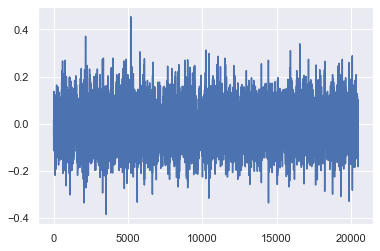

In [3]:
 val_ = data_1.values
v_ex=val_[:,0]
plt.plot(v_ex)

In [4]:
for filename in sorted(os.listdir(data_dir)):
    d_ = pd.read_csv(os.path.join(data_dir,filename), sep='\t', header=None)
    dat_val_ = d_.values
    d_lower = min(dat_val_[:,0])
    d_upper = max(dat_val_[:,0])
    d_rms = np.sqrt(np.mean(dat_val_[:,0]**2))
    d_kurt = sp.stats.kurtosis(dat_val_[:,0])
    d_wf = d_rms/((abs(dat_val_[:,0])).mean())
    d_raw = np.array([d_lower, d_upper, d_rms, d_kurt,d_wf])

    d_merged = pd.DataFrame(d_raw.reshape(1,5))
    d_merged.index = [filename]
    merged_data = merged_data.append(d_merged)
merged_data.head()

,0,1,2,3,4
2004.02.12.10.32.39,-0.386,0.454,0.074179,0.628763,1.271660
2004.02.12.10.42.39,-0.388,0.369,0.075382,0.648291,1.277742
2004.02.12.10.52.39,-0.400,0.503,0.076230,0.513475,1.265456
2004.02.12.11.02.39,-0.576,0.608,0.078724,1.157953,1.281033
2004.02.12.11.12.39,-0.391,0.391,0.078474,0.603177,1.278896


In [5]:
merged_data.columns = ['Bearing L','Bearing U', 'RMS', 'Kurtosis','WF'] #'WF'
mat1 = merged_data['Bearing L'];
mat2 = merged_data['Bearing U'];
time_w = np.arange(1,985)



Text(0, 0.5, 'Amplitude / (m/s^2)')

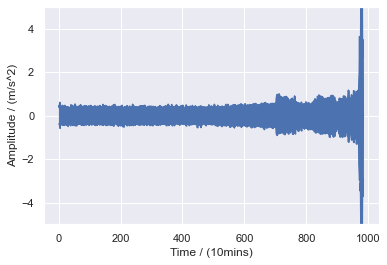

In [6]:
plt.figure()
plt.plot(time_w,mat1, 'b-')
plt.plot(time_w,mat2, 'b-')
plt.fill_between(time_w, mat1,mat2,color='b', alpha=1)
plt.ylim(-5,5)
plt.xlabel('Time / (10mins)')
plt.ylabel('Amplitude / (m/s^2)')

In [7]:
M_ = 20
wf_val = np.array(merged_data['WF'].values)
wfe_base = (wf_val)*np.log10(wf_val)

In [8]:
time_ind = np.arange(1,985) 
WFE_t = np.zeros(984,) # WF를 이용한 WFE계산
for tim in time_ind:
    if tim <= 20:
        WFE_t[tim-1] = sum(wfe_base[0:tim],)/(tim)
    else:
        WFE_t[tim-1] = sum(wfe_base[tim-20:tim],)/M_
        
merged_data = merged_data.drop('WF',axis=1)
merged_data['WFE'] = WFE_t


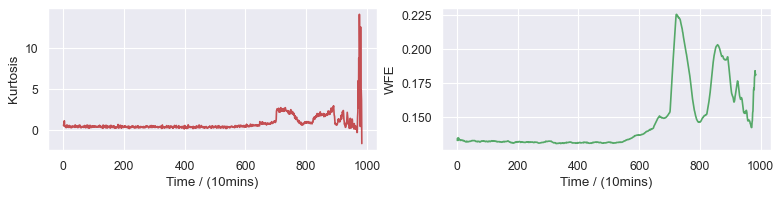

In [9]:
fig2 = plt.figure(figsize=(18,8), dpi=80)
#ax1 = fig2.add_subplot(3,3,1)
ax2 = fig2.add_subplot(3,3,2)
ax3 = fig2.add_subplot(3,3,3)
#ax1.plot(time_w, merged_data['RMS'],'b-',label='RMS')
#ax1.set_xlabel('Time / (10mins)')
#ax1.set_ylabel('RMS of amplitude / (m/s^2)')
ax2.plot(time_w, merged_data['Kurtosis'],'r-', label='Kurtosis')
ax2.set_xlabel('Time / (10mins)')
ax2.set_ylabel('Kurtosis')
ax3.plot(time_w, WFE_t,'g-', label='Entropy')
ax3.set_xlabel('Time / (10mins)')
ax3.set_ylabel('WFE')
plt.show()

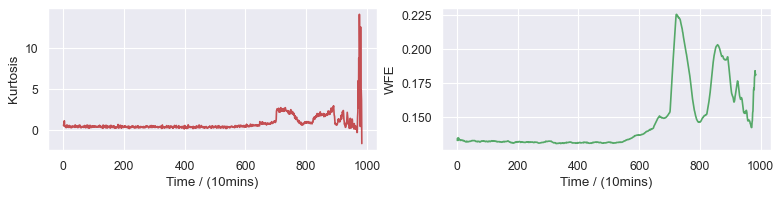

In [10]:
fig2 = plt.figure(figsize=(18,8), dpi=80)
#ax1 = fig2.add_subplot(3,3,1)
ax2 = fig2.add_subplot(3,3,2)
ax3 = fig2.add_subplot(3,3,3)
#ax1.plot(time_w, merged_data['RMS'],'b-',label='RMS')
#ax1.set_xlabel('Time / (10mins)')
#ax1.set_ylabel('RMS of amplitude / (m/s^2)')
ax2.plot(time_w, merged_data['Kurtosis'],'r-', label='Kurtosis')
ax2.set_xlabel('Time / (10mins)')
ax2.set_ylabel('Kurtosis')
ax3.plot(time_w, WFE_t,'g-', label='Entropy')
ax3.set_xlabel('Time / (10mins)')
ax3.set_ylabel('WFE')
plt.show()

In [11]:
exp1_label = np.array([])  #라벨링, 논문 기반으로 300~450 정상상태, 700~900 이상 상태 각각 0, 1로라벨링
for c_i in range(984):
    if (c_i>299)&(c_i<=449):
        exp1_label = np.append(exp1_label, 0)
    elif (c_i>699)&(c_i<=899):
        exp1_label = np.append(exp1_label, 1)
    else:
        exp1_label = np.append(exp1_label, 0.5)
        
merged_data['class'] = exp1_label

DataLogistic = np.array([])

DataLog = merged_data[(merged_data['class'] == 0.5)].index
DataLogistic = merged_data.drop(DataLog)

merged_data



,Bearing L,Bearing U,RMS,Kurtosis,WFE,class
2004.02.12.10.32.39,-0.386,0.454,0.074179,0.628763,0.132724,0.5
2004.02.12.10.42.39,-0.388,0.369,0.075382,0.648291,0.134366,0.5
2004.02.12.10.52.39,-0.400,0.503,0.076230,0.513475,0.132707,0.5
2004.02.12.11.02.39,-0.576,0.608,0.078724,1.157953,0.133977,0.5
2004.02.12.11.12.39,-0.391,0.391,0.078474,0.603177,0.134508,0.5
...,...,...,...,...,...,...
2004.02.19.05.42.39,-5.000,4.998,0.725001,12.577705,0.179010,0.5
2004.02.19.05.52.39,-2.881,2.688,0.462012,3.759972,0.181128,0.5
2004.02.19.06.02.39,-3.696,3.501,0.483835,4.891755,0.184132,0.5
2004.02.19.06.12.39,0.000,0.005,0.002103,3.637513,0.180715,0.5


여기까지가 데이터 전처리, 984 * 20480개의 진동데이터로부터 984행, 5열의 데이터 추출 


로지스틱-----------------------------

In [61]:
scaler = MinMaxScaler()

ad = pd.concat([merged_data['Kurtosis'],merged_data['WFE']],axis=1).values
ad_ = ad.copy()
ad_ = scaler.fit_transform(ad_)

merged_data['Kurtosis'] = ad_[:,0]
merged_data['WFE'] = ad_[:,1]
train_set = merged_data[merged_data['class'].isin([0,1])]
train_set = train_set.drop(['Bearing L', 'Bearing U', 'RMS'], axis=1)
b_value = train_set.values




Xlog = merged_data.iloc[:,:5]
ylog = merged_data.iloc[:,5]



In [62]:
from sklearn import neighbors, datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

In [63]:
scaler = MinMaxScaler()

scaler = scaler.fit_transform(DataLogistic)


In [64]:
#로지스틱 회귀분석
X = scaler[:,:5]
y = scaler[:,5]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False,  random_state=0)

log = LogisticRegression() #로지스틱 회귀분석 시행
log.fit(x_train, y_train) #모델의 정확도 확인
print('학습용 데이터셋 정확도 : %.2f' % log.score(x_train, y_train))
print('검증용 데이터셋 정확도 : %.2f' % log.score(x_test, y_test))



학습용 데이터셋 정확도 : 0.97
검증용 데이터셋 정확도 : 0.75


In [65]:
scaler = MinMaxScaler()


Xlog = merged_data.iloc[:,:5]
ylog = merged_data.iloc[:,5]

scalerLOG = scaler.fit_transform(Xlog)

scalerLOG

array([[9.22800000e-01, 9.04723779e-02, 1.00413830e-01, 1.42402515e-01,
        2.44927480e-02],
       [9.22400000e-01, 7.34587670e-02, 1.02077285e-01, 1.43644800e-01,
        4.17042722e-02],
       [9.20000000e-01, 1.00280224e-01, 1.03248473e-01, 1.35068614e-01,
        2.43086054e-02],
       ...,
       [2.60800000e-01, 7.00360288e-01, 6.66653081e-01, 4.13588989e-01,
        5.63617077e-01],
       [1.00000000e+00, 6.00480384e-04, 7.88256826e-04, 3.33801464e-01,
        5.27776687e-01],
       [9.99000000e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        5.35012590e-01]])

In [66]:
pred_y = log.predict(scalerLOG) # y예측, 1이 될 확률을 나타낸 결과

def cut(y, threshold): # 임계값 설정 함수
    Y = y.copy()
    Y[Y>threshold] = 1
    Y[Y<threshold] = 0
    return Y.astype(int)

pred_Y = cut(pred_y, 0.5) # 임계값에 따라 일정 값을 넘으면 1로 라벨링 되게 함
pred_Y


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [67]:
modelG = GaussianNB()
modelG.fit(x_train, y_train)

GaussianNB()

In [74]:
modelG.predict(x_test)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [75]:
predict_data = np.array(x_test[0])

In [76]:
clf = GaussianNB().fit(X,y)
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y, log.predict_proba(X)[:, 1])
fpr, tpr, thresholds


(array([0., 0., 0., 1.]),
 array([0.   , 0.005, 1.   , 1.   ]),
 array([1.99888099, 0.99888099, 0.26137984, 0.02786686]))

In [77]:
#auc
from sklearn.metrics import auc
auc(fpr, tpr)

1.0

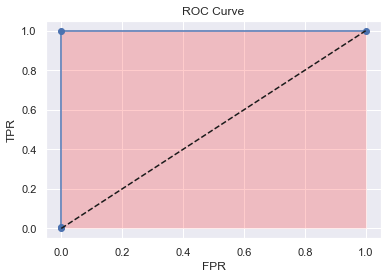

In [78]:
plt.plot(fpr, tpr, 'o-')
plt.plot([0,1],[0,1],'k--',label='random')
plt.fill_between(fpr,tpr,0,facecolor='red',alpha=0.2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.show()

In [79]:
merged_data2 = pd.DataFrame()

for filename in sorted(os.listdir(data_dir)):
    d_2 = pd.read_csv(os.path.join(data_dir,filename), sep='\t', header=None)
    dat_val_2 = d_2.values
    d_lower2 = min(dat_val_2[:,1])
    d_upper2 = max(dat_val_2[:,1])
    d_rms2 = np.sqrt(np.mean(dat_val_2[:,1]**2))
    d_kurt2 = sp.stats.kurtosis(dat_val_2[:,1])
    d_wf2 = d_rms/((abs(dat_val_2[:,1])).mean())
    d_raw2 = np.array([d_lower2, d_upper2, d_rms2, d_kurt2,d_wf2])

    d_merged2 = pd.DataFrame(d_raw2.reshape(1,5))
    d_merged2.index = [filename]
    merged_data2 = merged_data2.append(d_merged2)
merged_data2.head()

,0,1,2,3,4
2004.02.12.10.32.39,-0.513,0.464,0.090944,0.506801,0.021338
2004.02.12.10.42.39,-0.481,0.457,0.093419,0.253014,0.020710
2004.02.12.10.52.39,-0.503,0.491,0.093718,0.310789,0.020650
2004.02.12.11.02.39,-0.474,0.569,0.092947,0.235341,0.020757
2004.02.12.11.12.39,-0.486,0.452,0.095348,0.226309,0.020273


In [80]:
merged_data2.columns = ['Bearing L','Bearing U', 'RMS', 'Kurtosis','WF'] #'WF'
mat1 = merged_data['Bearing L'];
mat2 = merged_data['Bearing U'];
time_w = np.arange(1,985)

scaler = MinMaxScaler()

merged_data2
scaler2 = scaler.fit_transform(merged_data2)


In [81]:
pred_y = log.predict(scaler2) # y예측, 1이 될 확률을 나타낸 결과

def cut(y, threshold): # 임계값 설정 함수
    Y = y.copy()
    Y[Y>threshold] = 1
    Y[Y<threshold] = 0
    return Y.astype(int)

pred_Y = cut(pred_y, 0.5) # 임계값에 따라 일정 값을 넘으면 1로 라벨링 되게 함
pred_Y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [82]:
#XKmeans = merged_data.iloc[:,3]
#XKmeans2 = merged_data.iloc[:,4]

#K_X = np.vstack((XKmeans, XKmeans2)).T

XKmeans_L = merged_data.iloc[:,0]
XKmeans_U = merged_data.iloc[:,1]

K_X2 = np.vstack((XKmeans_L, XKmeans_U)).T

In [89]:

from sklearn.cluster import KMeans

scaler = MinMaxScaler()
sca_K = scaler.fit_transform(K_X2)


k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(K_X2)
#y_pred = kmeans.fit_predict(sca_K) #스케일이 같으므로 정규화 하지 않았다. 
y_pred


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [90]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=35, linewidths=8, color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=2, linewidths=12, color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                            show_xlabels = True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy= np.meshgrid(np.linspace(mins[0],maxs[0],resolution), np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)
    
    if show_xlabels:
        plt.xlabel("$Lower$",fontsize=14)
    else:
        plt.tick_params(labelbottom = False)
    if show_ylabels:
        plt.ylabel("$Upper$", fontsize = 14, rotation = 0)
    else:
        plt.tick_params(labelleft=False)

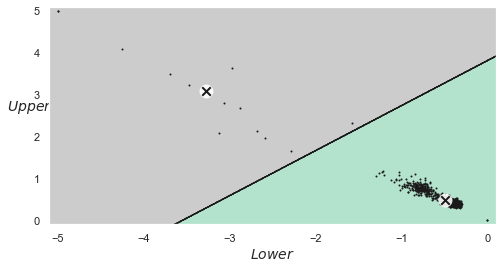

In [85]:
plt.figure(figsize=(8,4))
plot_decision_boundaries(kmeans,K_X2)
plt.show()

------ up, low kmeans 끝


In [86]:
XKmeans = merged_data.iloc[:,3]
XKmeans2 = merged_data.iloc[:,4]

K_X = np.vstack((XKmeans, XKmeans2)).T

In [88]:
from sklearn.cluster import KMeans

scaler = MinMaxScaler()
sca_K1 = scaler.fit_transform(K_X)


k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(sca_K1)
y_pred



array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [33]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=35, linewidths=8, color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=2, linewidths=12, color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                            show_xlabels = True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy= np.meshgrid(np.linspace(mins[0],maxs[0],resolution), np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)
    
    if show_xlabels:
        plt.xlabel("$kurtosis$",fontsize=14)
    else:
        plt.tick_params(labelbottom = False)
    if show_ylabels:
        plt.ylabel("$WFE$", fontsize = 14, rotation = 0)
    else:
        plt.tick_params(labelleft=False)

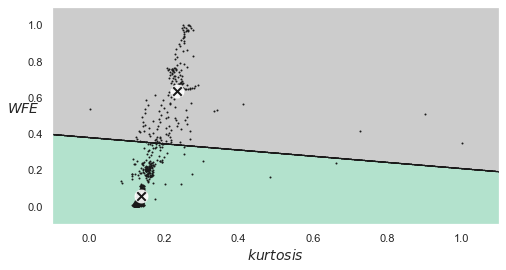

In [34]:
plt.figure(figsize=(8,4))
plot_decision_boundaries(kmeans,sca_K1)
plt.show()

In [119]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(sca_K1) for k in range(1,10)]
inertias = [model.inertia_ for model in kmeans_per_k]

In [ ]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("inertia", fontsize=14)
plt.annotate("Elbow", xy=(2, inertias[3]), xytext=(0.55, 0.55), textcoords="figure fraction", fontsize = 16,
             arrowprops = dict(facecolor = "black", shrink = 0.1)
            )
plt.axis([1, 8.5, 0, 200])
plt.show()

LSTM----------------

In [36]:
import os
import pandas as pd 
import numpy as np


import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt 
import scipy as sp

from numpy.random import seed
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed,RepeatVector
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

In [37]:
path = 'C:\\Users\\USER\\Desktop\\LSTMdata\\' 

data_1 = pd.read_csv(path + 'bearing2nd/2004.02.12.10.32.39',header = None, sep='\t')
#header=none 은 변수 이름이 없는 파일 불러오기
data_1.columns = ['bearing_1','bearing_2','bearing_3','beaing_4']

data_1.shape

data_dir = path + '/bearing2nd'
merged_data = pd.DataFrame()

In [38]:
for filename in sorted(os.listdir(data_dir)):
    d_ = pd.read_csv(os.path.join(data_dir,filename), sep='\t', header=None)
    dat_val_ = d_.values
    d_lower = min(dat_val_[:,0])
    d_upper = max(dat_val_[:,0])
    d_rms = np.sqrt(np.mean(dat_val_[:,0]**2))
    d_kurt = sp.stats.kurtosis(dat_val_[:,0])
    d_wf = d_rms/((abs(dat_val_[:,0])).mean())
    d_raw = np.array([d_lower, d_upper, d_rms, d_kurt,d_wf])
    d_merged = pd.DataFrame(d_raw.reshape(1,5))
    d_merged.index = [filename]
    merged_data = merged_data.append(d_merged)


In [39]:
merged_data.columns = ['Bearing L','Bearing U', 'RMS', 'Kurtosis','WF']
mat1 = merged_data['Bearing L'];
mat2 = merged_data['Bearing U'];
time_w = np.arange(1,985)


In [40]:
M_ = 20
wf_val = np.array(merged_data['WF'].values)
wfe_base = (wf_val)*np.log10(wf_val)

time_ind = np.arange(1,985)
WFE_t = np.zeros(984,)
for tim in time_ind:
    if tim <= 20:
        WFE_t[tim-1] = sum(wfe_base[0:tim],)/(tim)
    else:
        WFE_t[tim-1] = sum(wfe_base[tim-20:tim],)/M_
merged_data = merged_data.drop('WF',axis=1)
merged_data['WFE'] = WFE_t


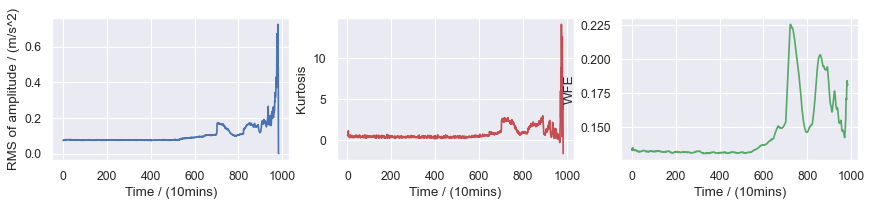

In [41]:
fig2 = plt.figure(figsize=(13,8), dpi=80)
ax1 = fig2.add_subplot(3,3,1)
ax2 = fig2.add_subplot(3,3,2)
ax3 = fig2.add_subplot(3,3,3)
ax1.plot(time_w, merged_data['RMS'],'b-',label='RMS')
ax1.set_xlabel('Time / (10mins)')
ax1.set_ylabel('RMS of amplitude / (m/s^2)')
ax2.plot(time_w, merged_data['Kurtosis'],'r-', label='Kurtosis')
ax2.set_xlabel('Time / (10mins)')
ax2.set_ylabel('Kurtosis')
ax3.plot(time_w, WFE_t,'g-', label='Entropy')
ax3.set_xlabel('Time / (10mins)')
ax3.set_ylabel('WFE')
plt.show()


In [42]:
exp1_label = np.array([])
for c_i in range(984):
    if (c_i>299)&(c_i<=449):
        exp1_label = np.append(exp1_label, 0)
    elif (c_i>699)&(c_i<=899):
        exp1_label = np.append(exp1_label, 1)
    else:
        exp1_label = np.append(exp1_label, 0.5)

merged_data['class'] = exp1_label

In [43]:
scaler = MinMaxScaler()

ad = pd.concat([merged_data['Kurtosis'],merged_data['WFE']],axis=1).values
ad_ = ad.copy()
ad_ = scaler.fit_transform(ad_)

merged_data['Kurtosis'] = ad_[:,0]
merged_data['WFE'] = ad_[:,1]

train_set = merged_data[merged_data['class'].isin([0,1])]
train_set = train_set.drop(['Bearing L', 'Bearing U', 'RMS'], axis=1)
b_value = train_set.values


In [44]:
seq_set = np.empty((0,2,2)) 
seq_lab = np.array([])
for t_seq in np.arange(0,349):
    if b_value[t_seq,2]==b_value[t_seq+1,2]:
        sequ2 = np.reshape(b_value[t_seq:t_seq+2,0:2],(1,2,2))
        seq_set=np.concatenate([seq_set,sequ2]) 
        seq_lab=np.append(seq_lab, b_value[t_seq+1,2])

In [45]:
model = Sequential()
model.add(LSTM(units=30, input_shape=(2,2),return_sequences=True)) 
model.add(LSTM(units=30,return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(1,activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

model.fit(seq_set, seq_lab, epochs=100, batch_size=10)

Epoch 1/100
35/35 [==============================] - 3s 2ms/step - loss: 0.6882 - accuracy: 0.5721
Epoch 2/100
35/35 [==============================] - 0s 2ms/step - loss: 0.6438 - accuracy: 0.5615
Epoch 3/100
35/35 [==============================] - 0s 2ms/step - loss: 0.4587 - accuracy: 0.6211
Epoch 4/100
35/35 [==============================] - 0s 2ms/step - loss: 0.2643 - accuracy: 1.0000
Epoch 5/100
35/35 [==============================] - 0s 2ms/step - loss: 0.1262 - accuracy: 1.0000
Epoch 6/100
35/35 [==============================] - 0s 2ms/step - loss: 0.0457 - accuracy: 1.0000
Epoch 7/100
35/35 [==============================] - 0s 2ms/step - loss: 0.0203 - accuracy: 1.0000
Epoch 8/100
35/35 [==============================] - 0s 2ms/step - loss: 0.0101 - accuracy: 1.0000
Epoch 9/100
35/35 [==============================] - 0s 2ms/step - loss: 0.0070 - accuracy: 1.0000
Epoch 10/100
35/35 [==============================] - 0s 2ms/step - loss: 0.0047 - accuracy: 1.0000
Epoch 11/

In [96]:
u_set = merged_data.drop(['Bearing L', 'Bearing U', 'RMS', 'class'], axis=1)
b_value = u_set.values
u_seq = np.empty((0,2,2))
for t_seq in np.arange(0,983):
    sequ2 = np.reshape(b_value[t_seq:t_seq+2,0:2],(1,2,2))
    u_seq=np.concatenate([u_seq,sequ2])

pred_pof = model.predict(u_seq)
pred_pon = 1-pred_pof
time_w = np.arange(0,983)


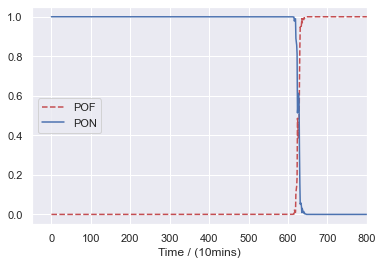

In [97]:
plt.plot(time_w, pred_pof, 'r--', label = 'POF')
plt.plot(time_w, 1-pred_pof, 'b-', label = 'PON')

plt.xlabel('Time / (10mins)')
plt.xlim(right=800)
plt.legend()

In [98]:
path = 'C:\\Users\\USER\\Desktop\\LSTMdata\\' 

data_1 = pd.read_csv(path + 'bearing2nd/2004.02.12.10.32.39',header = None, sep='\t')
#header=none 은 변수 이름이 없는 파일 불러오기
data_1.columns = ['bearing_1','bearing_2','bearing_3','beaing_4']

data_1.shape

data_dir = path + '/bearing2nd'
merged_data = pd.DataFrame()

for filename in sorted(os.listdir(data_dir)):
    d_ = pd.read_csv(os.path.join(data_dir,filename), sep='\t', header=None)
    dat_val_ = d_.values
    d_lower = min(dat_val_[:,0])
    d_upper = max(dat_val_[:,0])
    d_rms = np.sqrt(np.mean(dat_val_[:,0]**2))
    d_kurt = sp.stats.kurtosis(dat_val_[:,0])
    d_wf = d_rms/((abs(dat_val_[:,0])).mean())
    d_raw = np.array([d_lower, d_upper, d_rms, d_kurt,d_wf])
    d_merged = pd.DataFrame(d_raw.reshape(1,5))
    d_merged.index = [filename]
    merged_data = merged_data.append(d_merged)


merged_data.columns = ['Bearing L','Bearing U', 'RMS', 'Kurtosis','WF']
mat1 = merged_data['Bearing L'];
mat2 = merged_data['Bearing U'];
time_w = np.arange(1,985)


M_ = 20
wf_val = np.array(merged_data['WF'].values)
wfe_base = (wf_val)*np.log10(wf_val)

time_ind = np.arange(1,985)
WFE_t = np.zeros(984,)
for tim in time_ind:
    if tim <= 20:
        WFE_t[tim-1] = sum(wfe_base[0:tim],)/(tim)
    else:
        WFE_t[tim-1] = sum(wfe_base[tim-20:tim],)/M_
merged_data = merged_data.drop('WF',axis=1)
merged_data['WFE'] = WFE_t


exp1_label = np.array([])
for c_i in range(984):
    if (c_i>299)&(c_i<=449):
        exp1_label = np.append(exp1_label, 0)
    elif (c_i>699)&(c_i<=899):
        exp1_label = np.append(exp1_label, 1)
    else:
        exp1_label = np.append(exp1_label, 0.5)

merged_data['class'] = exp1_label

scaler = MinMaxScaler()

ad = pd.concat([merged_data['Kurtosis'],merged_data['WFE']],axis=1).values
ad_ = ad.copy()
ad_ = scaler.fit_transform(ad_)

merged_data['Kurtosis'] = ad_[:,0]
merged_data['WFE'] = ad_[:,1]

train_set = merged_data[merged_data['class'].isin([0,1])]
train_set = train_set.drop(['Bearing L', 'Bearing U', 'RMS'], axis=1)
b_value = train_set.values

In [99]:
t = 650
number = 55
exp2_label = np.zeros(984)

In [100]:
for s_i in range(6):
    vec_zero = np.zeros(t+s_i*number)
    vec_one = np.ones(984-t-s_i*number)
    dum_vec = np.concatenate([vec_zero,vec_one])
    exp2_label = exp2_label + dum_vec

In [101]:
a = np.ones(55)
b = np.zeros(55)
dum_vec2 = np.concatenate([a,b])
dum_vec2
exp2_label

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [107]:
b_value = u_set.values
seq_set = np.empty((0,4,2))
seq_lab = np.array([])

u_set['exp2_label']=exp2_label

b_value

array([[0.14240252, 0.02449275, 0.        ],
       [0.1436448 , 0.04170427, 0.        ],
       [0.13506861, 0.02430861, 0.        ],
       ...,
       [0.41358899, 0.56361708, 6.        ],
       [0.33380146, 0.52777669, 6.        ],
       [0.        , 0.53501259, 6.        ]])

In [108]:
seq_set.shape

(0, 4, 2)

In [109]:
pd.DataFrame(b_value)

,0,1,2
0,0.142403,0.024493,0.0
1,0.143645,0.041704,0.0
2,0.135069,0.024309,0.0
3,0.176066,0.037631,0.0
4,0.140775,0.043197,0.0
...,...,...,...
979,0.902524,0.509893,6.0
980,0.341592,0.532110,6.0
981,0.413589,0.563617,6.0
982,0.333801,0.527777,6.0


In [110]:
for t_seq in np.arange(0,981):
    if b_value[t_seq,2]==b_value[t_seq+3,2]:
        sequ2 = np.reshape(b_value[t_seq:t_seq+4,0:2],(1,4,2))
        seq_set=np.concatenate([seq_set,sequ2]) 
        seq_lab=np.append(seq_lab, b_value[t_seq+3,2])

In [111]:
tr_x = np.empty((0,4,2))
ts_x = np.empty((0,4,2))
tr_y = np.empty(0)
ts_y = np.empty(0)
for i in range(0,7): #각각 라벨링 된 값들을 고르게 train, test셋으로 나눠줌
    split_buf = train_test_split(seq_set[seq_lab==i], test_size=0.3)
    tr_x = np.concatenate([tr_x, split_buf[0]])
    tr_y = np.append(tr_y, np.zeros(len(split_buf[0]))+i)
    ts_x = np.concatenate([ts_x, split_buf[1]])
    ts_y = np.append(ts_y, np.zeros(len(split_buf[1]))+i)


In [116]:
model = Sequential()
model.add(LSTM(100, input_shape=(4,2), return_sequences=True))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(7,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(tr_x,tr_y, epochs=200, validation_data=(ts_x,ts_y))


Epoch 1/200
21/21 [==============================] - 4s 37ms/step - loss: 1.8552 - accuracy: 0.5779 - val_loss: 1.1232 - val_accuracy: 0.6678
Epoch 2/200
21/21 [==============================] - 0s 5ms/step - loss: 1.0442 - accuracy: 0.6982 - val_loss: 0.7664 - val_accuracy: 0.7192
Epoch 3/200
21/21 [==============================] - 0s 5ms/step - loss: 0.6870 - accuracy: 0.7382 - val_loss: 0.6152 - val_accuracy: 0.7226
Epoch 4/200
21/21 [==============================] - 0s 4ms/step - loss: 0.6052 - accuracy: 0.7241 - val_loss: 0.5927 - val_accuracy: 0.7260
Epoch 5/200
21/21 [==============================] - 0s 4ms/step - loss: 0.5653 - accuracy: 0.7392 - val_loss: 0.5793 - val_accuracy: 0.7397
Epoch 6/200
21/21 [==============================] - 0s 4ms/step - loss: 0.5418 - accuracy: 0.7391 - val_loss: 0.5632 - val_accuracy: 0.7363
Epoch 7/200
21/21 [==============================] - 0s 4ms/step - loss: 0.5692 - accuracy: 0.7500 - val_loss: 0.5465 - val_accuracy: 0.7466
Epoch 8/200


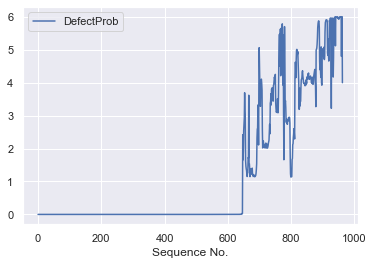

In [120]:
pre_ = model.predict(seq_set)
Prob = np.array([0,1,2,3,4,5,6])
DefectProb = pre_@Deg_i

fig_ = plt.figure()
plt.plot(Deg, 'b-', label = 'DefectProb')
plt.xlabel('Sequence No.')
plt.legend()


In [118]:
seq_set

array([[[0.14240252, 0.02449275],
        [0.1436448 , 0.04170427],
        [0.13506861, 0.02430861],
        [0.17606647, 0.03763144]],

       [[0.1436448 , 0.04170427],
        [0.13506861, 0.02430861],
        [0.17606647, 0.03763144],
        [0.1407749 , 0.04319738]],

       [[0.13506861, 0.02430861],
        [0.17606647, 0.03763144],
        [0.1407749 , 0.04319738],
        [0.13141833, 0.03845149]],

       ...,

       [[0.13223029, 0.41667788],
        [0.90252381, 0.50989283],
        [0.34159159, 0.53210955],
        [0.41358899, 0.56361708]],

       [[0.90252381, 0.50989283],
        [0.34159159, 0.53210955],
        [0.41358899, 0.56361708],
        [0.33380146, 0.52777669]],

       [[0.34159159, 0.53210955],
        [0.41358899, 0.56361708],
        [0.33380146, 0.52777669],
        [0.        , 0.53501259]]])